In [1]:
!pwd


/workspace/XCache


In [20]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
import pandas as pd

start_date = '2018-08-01 00:00:00'
end_date = '2018-09-01 00:00:00'
#site = 'LRZ-LMU'
#site = 'DESY-HH'
site = 'MPPMU'

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'], timeout=60)
indices = "traces"

print("start:", start_date, "end:", end_date)
start = int(pd.Timestamp(start_date).timestamp())
end = int(pd.Timestamp(end_date).timestamp())

kind = 'prod'

my_query = {
    "_source": ["time_start", "time_end", "site", "event", "scope", "filename", "filesize"],
    'query': {
        'bool': {
            'must': [
                {'range': {'time_start': {'gte': start, 'lt': end}}},
                {'exists': {"field": "filename"}},
                {'wildcard': {'site': site + '*'}},
                # {'wildcard': {'filename': 'EVNT*'}},
                #{'wildcard': {'event': 'get_sm*'}},
                {'term': {'event': 'get_sm'}},
                # {'term': {'event': 'get_sm_a'}},
                # {'term': {'event': 'download'}},
            ]
        }
    }
}

dataset = 'AUG'

scroll = scan(client=es, index=indices, query=my_query)
count = 0
requests = []
for res in scroll:
    r = res['_source']
    requests.append([r['scope'] + ':' + r['filename'], r['filesize'], r['time_start']])

    if not count % 100000:
        print(count)
        print(res)
    count = count + 1

all_accesses = pd.DataFrame(requests).sort_values(2)
all_accesses.columns = ['filename', 'filesize', 'transfer_start']
all_accesses.set_index('filename', drop=True, inplace=True)
all_accesses.to_hdf(site + '_' + kind + '_' + dataset + '.h5', key=site, mode='w', complevel=1)

start: 2018-08-01 00:00:00 end: 2018-09-01 00:00:00
0
{'sort': [6], '_id': '4395ea98d20d45c191729bd24f3d681b', '_type': 'docs', '_source': {'site': 'MPPMU_DATADISK', 'time_end': 1535446034.319659, 'time_start': 1535445507.69399, 'filename': 'HITS.10701323._005535.pool.root.1', 'event': 'get_sm', 'filesize': 3170874434, 'scope': 'mc16_13TeV'}, '_index': 'traces-2018-08-28', '_score': None}
100000
{'sort': [952885], '_id': '5dbf9d677b4d44618380d64a430da762', '_type': 'docs', '_source': {'site': 'MPPMU_DATADISK', 'time_end': 1534686607.865187, 'time_start': 1534686265.883446, 'filename': 'HITS.10701323._005458.pool.root.1', 'event': 'get_sm', 'filesize': 3159289397, 'scope': 'mc16_13TeV'}, '_index': 'traces-2018-08-19', '_score': None}
200000
{'sort': [1505726], '_id': '5bd02c002f2f4521af0770ac599ad759', '_type': 'docs', '_source': {'site': 'MPPMU_DATADISK', 'time_end': 1533979110.588866, 'time_start': 1533979103.007696, 'filename': 'EVNT.13912617._000039.pool.root.1', 'event': 'get_sm', 

## Access Histos ##

In [3]:
!pwd

/workspace/XCache


LRZ-LMU AUG prod 323247
      site month  kind   files  unique files  total size [PB]  \
0  LRZ-LMU   AUG  prod  323247        177722         0.544677   

   avg. filesize [GB]  
0             1.76687  
                 total  unique  avgFSize  inf. cache hit rate    uniqueFSize
group               24       3  0.024444             0.875000       0.073331
EVNT             99769   22484  0.252505             0.774639    5677.331839
HITS             42533   13378  2.209623             0.685468   29560.334675
data18_13TeV     30416   16167  3.100179             0.468471   50120.600181
DAOD_TRUTH1        355     212  8.412264             0.402817    1783.399899
AOD             150144   97127  2.351487             0.353108  228392.870000
log               1421    1222  0.011230             0.140042      13.723130
DESDM_ALLCELLS    3328    2867  0.640930             0.138522    1837.546768
DAOD_TRUTH3         30      26  0.034737             0.133333       0.903158
TXT              11172   10

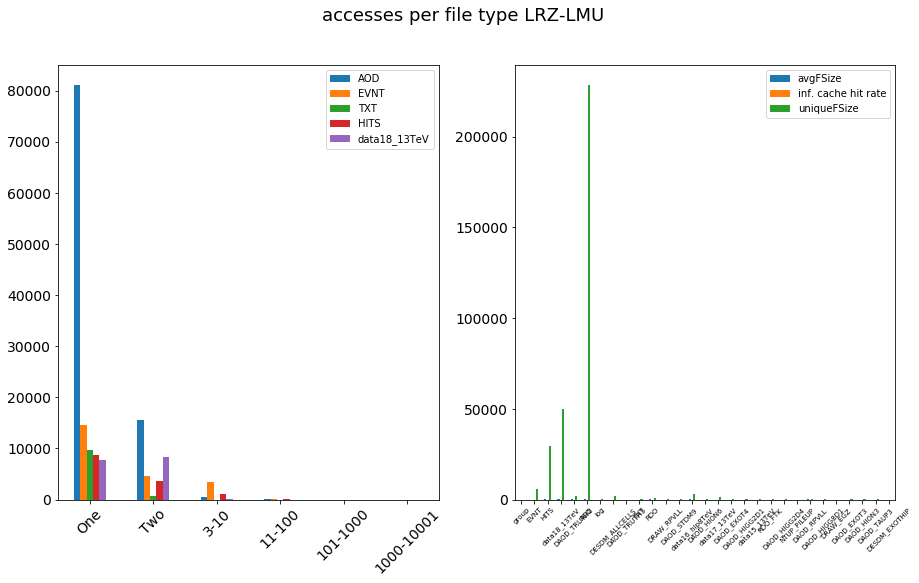

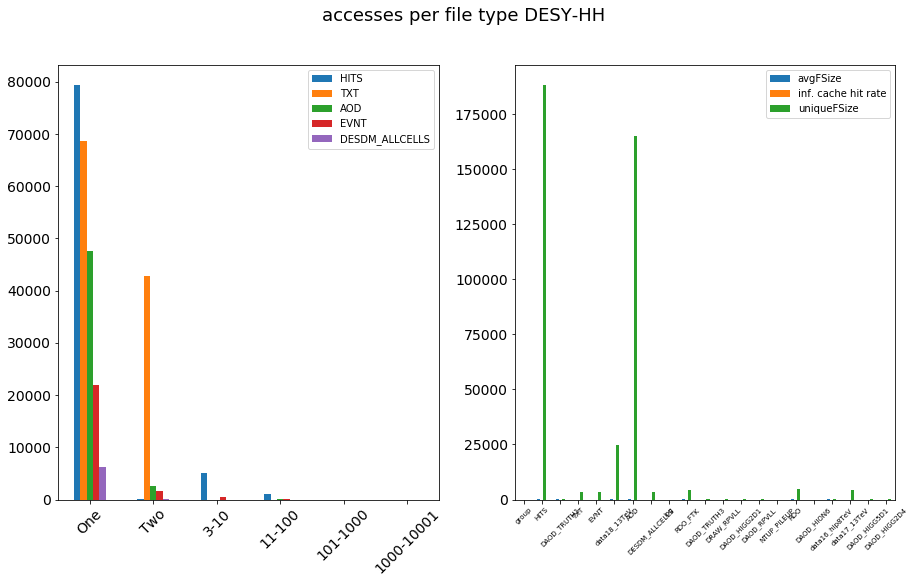

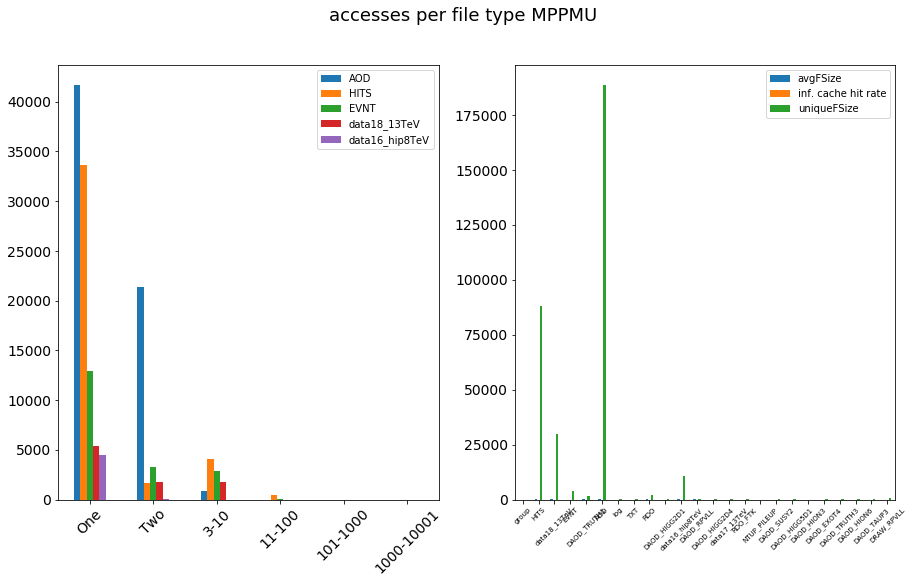

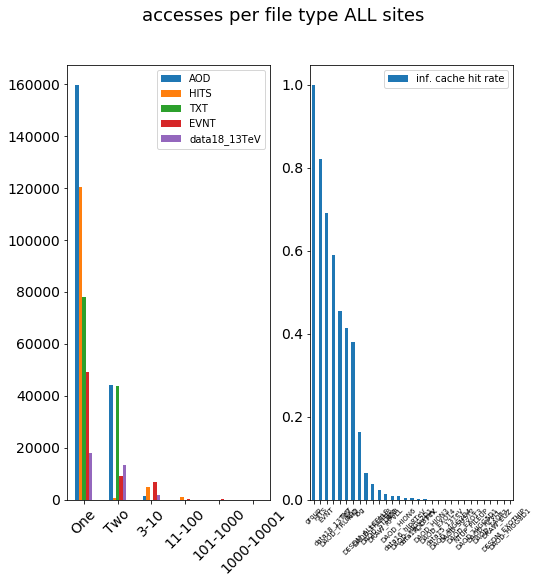

In [22]:
#GD
# input files e.g. ../data/AUG/LRZ-LMU_prod_AUG.h5

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cache import load_data

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

step = 10000

MB = 1024 * 1024
GB = 1024 * MB
TB = 1024 * GB
PB = 1024 * TB

#sites = ['MWT2', 'AGLT2', 'NET2', 'SWT2', 'BNL']  # , 'OU_OSCER',  'UTA_SWT2',
sites = ['LRZ-LMU','DESY-HH','MPPMU']
#sites = ['LRZ-LMU']
filetypes = []

periods = ['AUG']  # must be listed in order
kinds = ['prod']  # prod
title = ','.join(sites)

bs = [1, 2, 10, 100, 1000, 10000, 100000]
sites_data = []


def get_type(s):
    f = s.split(":")[1]
    return f.split('.')[0]


for site in sites:
    site_data = load_data([site], periods, kinds)

    # get filetypes
    fts = []
    accpft = []
    totalacc = []
    dt = site_data.groupby(by=get_type)
    for name, group in dt:
        # print(name)  # , group)
        grouped = group.groupby('filename')
        gc = grouped.size().sort_values(ascending=False)  # series
        count, division = np.histogram(gc, bins=bs)
        # print('frequencies:')
        # print(division)
        # print(count)
        totalacc.append([group.shape[0], group.index.unique().shape[0], group.filesize.mean()/GB])
        fts.append(name)
        accpft.append(count)

    accdf = pd.DataFrame(accpft, index=fts, columns=['One', 'Two', '3-10', '11-100',
                                                     '101-1000', '1000-10001']).sort_values("One", ascending=False)

    totdf = pd.DataFrame(totalacc, index=fts, columns=['total', 'unique','avgFSize'])
    totdf['inf. cache hit rate'] = (totdf.total - totdf.unique) / totdf.total
    totdf['uniqueFSize'] = totdf.unique * totdf.avgFSize
    totdf.sort_values('inf. cache hit rate', ascending=False, inplace=True)
    print(totdf)
    
    print('Sum Unique Filesize :', totdf.uniqueFSize.sum())

    accdf = accdf[0:5]
    print(accdf)

    # put together in a stacked plot.
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    title = 'accesses per file type ' + site
    fig.suptitle(title, fontsize=18)
    accdf.transpose().plot(ax=ax[0], kind='bar', stacked=False, logy=False, rot=45)

    totdf = totdf.drop(columns=["total", "unique"])
    ax[1].tick_params(axis='x', which='major', labelsize=7)
    totdf.plot(ax=ax[1], kind='bar', rot=45)

    fig.savefig(title.replace(' ', '_') + '.png')

    sites_data.append(site_data)
    print('----------------------------')

all_data = pd.concat(sites_data)

#print(all_data.head())
all_data = all_data.sort_values('transfer_start')

print('---------- Fully merged -----------')
print(all_data.shape[0], 'files\t\t', all_data.index.unique().shape[0], 'unique files')
print(all_data.filesize.sum() / PB, "PB")
print(all_data.filesize.mean() / GB, "GB avg. file size")

fts = []
accpft = []
totalacc = []
dt = all_data.groupby(by=get_type)
for name, group in dt:
    # print(name)  # , group)
    #print (name, group.filesize.mean())
    grouped = group.groupby('filename')
    gc = grouped.size().sort_values(ascending=False)  # series
    count, division = np.histogram(gc, bins=bs)
    # print('frequencies:')
    # print(division)
    # print(count)
    fts.append(name)
    accpft.append(count)
    totalacc.append([group.shape[0], group.index.unique().shape[0], group.filesize.mean()/GB ])

accdf = pd.DataFrame(accpft, index=fts, columns=['One', 'Two', '3-10', '11-100',
                                                 '101-1000', '1000-10001']).sort_values("One", ascending=False)

accdf = accdf[0:5]
print(accdf)

totdf = pd.DataFrame(totalacc, index=fts, columns=['total', 'unique','avgFSize'])
totdf['inf. cache hit rate'] = (totdf.total - totdf.unique) / totdf.total
totdf.sort_values('inf. cache hit rate', ascending=False, inplace=True)
print(totdf)


# put together in a stacked plot.
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
title = 'accesses per file type ALL sites'
fig.suptitle(title, fontsize=18)
accdf.transpose().plot(ax=ax[0], kind='bar', stacked=False, logy=False, rot=45)

totdf = totdf.drop(columns=["total", "unique",'avgFSize'])
ax[1].tick_params(axis='x', which='major', labelsize=7)
totdf.plot(ax=ax[1], kind='bar', rot=45)

fig.savefig(title.replace(' ', '_') + '.png')
